In [ ]:
#import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
 
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Preparation & Preprocessing
def crop_brain_image(image, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

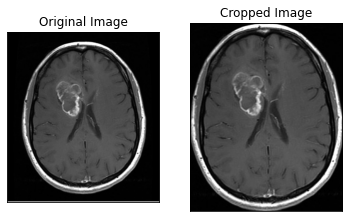

In [ ]:
example_img = cv2.imread('/content/drive/MyDrive/Brain Tumor/Dataset/yes/Y101.jpg')
example_new_img = crop_brain_image(example_img, True)

In [ ]:
# Load up the data:

def data_load(dir_list, image_size):
   # load all images in a directory
    x = []
    y = []
    image_width, image_height = image_size
    
    for direct in dir_list:
        for filename in listdir(direct):
            # load the image
            image = cv2.imread(direct + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_image(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            x.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if direct[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    x = np.array(x)
    y = np.array(y)
    
    # Shuffle the data
    x, y = shuffle(x, y)
    
    print(f'Number of examples is: {len(x)}')
    print(f'x shape is: {x.shape}')
    print(f'y shape is: {y.shape}')
    
    return x, y

In [ ]:
augmented_path = '/content/drive/MyDrive/Brain Tumor/Dataset/aug_data'
# augmented data (yes and no) contains both the original and the new generated examples
aug_yes = '/content/drive/MyDrive/Brain Tumor/Dataset/aug_data/yes' 
aug_no ='/content/drive/MyDrive/Brain Tumor/Dataset/aug_data/no'

img_WIDTH, img_HEIGHT = (240, 240)

x, y = data_load(['/content/drive/MyDrive/Brain Tumor/Dataset/aug_data/yes', '/content/drive/MyDrive/Brain Tumor/Dataset/aug_data/no'], (img_WIDTH, img_HEIGHT))

Number of examples is: 253
x shape is: (253, 240, 240, 3)
y shape is: (253, 1)


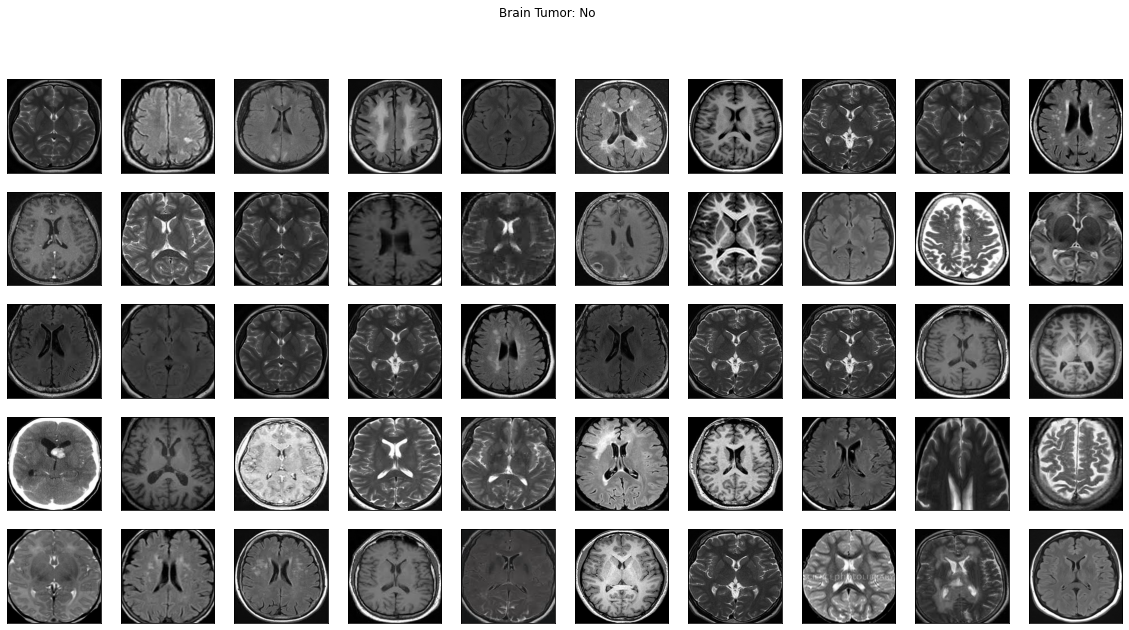

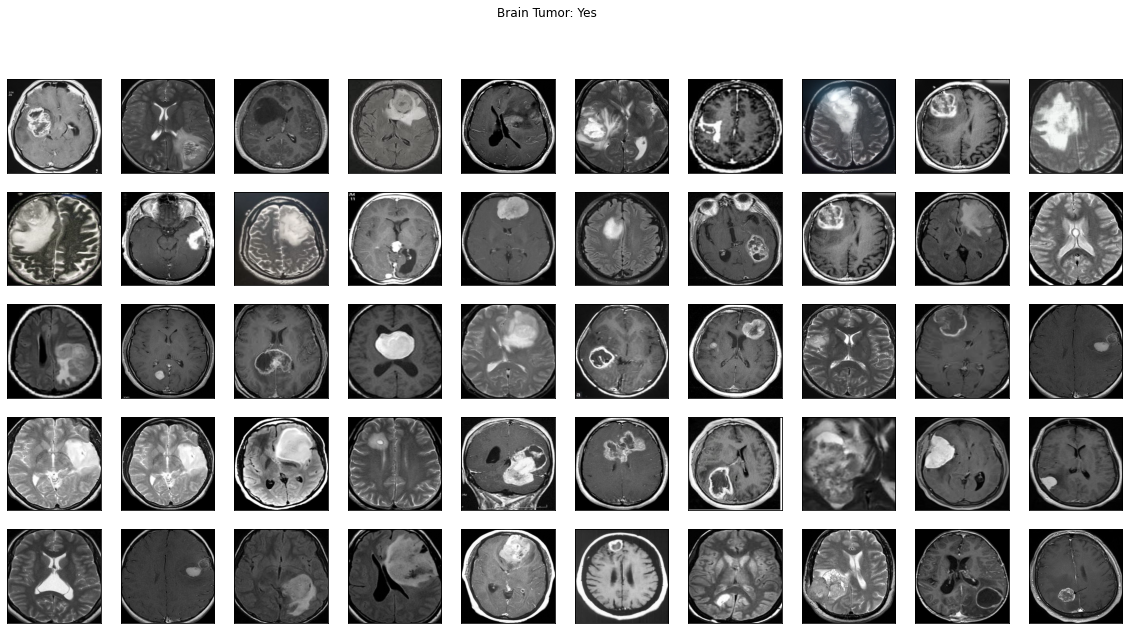

In [ ]:
# Plot sample images:
def plot_sample_images(x, y, n=50):
  for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = x[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

plot_sample_images(x, y)
   

In [ ]:
# split data
def split_data(x, y, test_size=0.2):
  x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=test_size)
  x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5)
    
  return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(x, y, test_size=0.3)

print ("number of training examples = " + str(x_train.shape[0]))
print ("number of development examples = " + str(x_val.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(x_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 177
number of development examples = 38
number of test examples = 38
X_train shape: (177, 240, 240, 3)
Y_train shape: (177, 1)
X_val (dev) shape: (38, 240, 240, 3)
Y_val (dev) shape: (38, 1)
X_test shape: (38, 240, 240, 3)
Y_test shape: (38, 1)


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [ ]:
# Build the model


def build_model(input_shape):
  # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [ ]:
IMG_SHAPE = (img_WIDTH, img_HEIGHT, 3)

In [ ]:
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

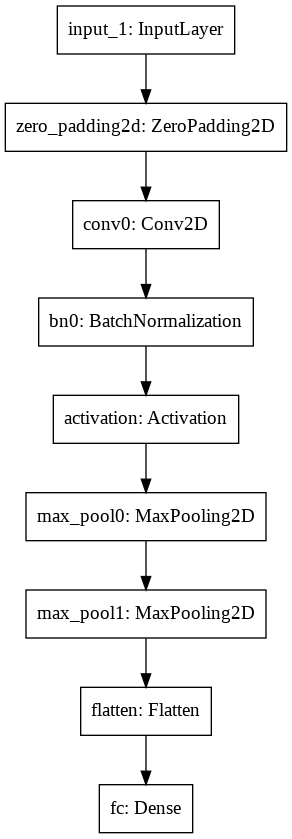

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='CNN_Layers.png')

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [ ]:
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [ ]:
start_time = time.time()

model.fit(x=x_train, y=y_train, batch_size=32, epochs=150, validation_data=(x_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/150
6/6 [==============================] - 14s 2s/step - loss: 1.1260 - accuracy: 0.5819 - val_loss: 0.7499 - val_accuracy: 0.5526
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.55.model/assets
Epoch 2/150
6/6 [==============================] - 14s 2s/step - loss: 0.7885 - accuracy: 0.6554 - val_loss: 0.6659 - val_accuracy: 0.6053
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.61.model/assets
Epoch 3/150
6/6 [==============================] - 13s 2s/step - loss: 0.6703 - accuracy: 0.6836 - val_loss: 0.6694 - val_accuracy: 0.5526
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.55.model/assets
Epoch 4/150
6/6 [==============================] - 13s 2s/step - loss: 0.4999 - accuracy: 0.7458 - val_loss: 0.6613 - val_accuracy: 0.5526
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-04-0.55.model/assets
Epoch 5/150
6/6 [==============================] - 13s 2s/step - loss: 0.4518 - accu

In [ ]:
history = model.history.history

for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


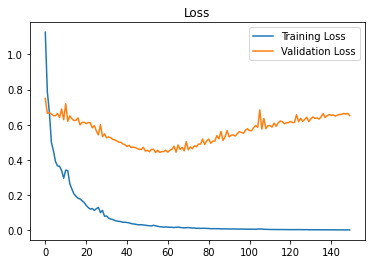

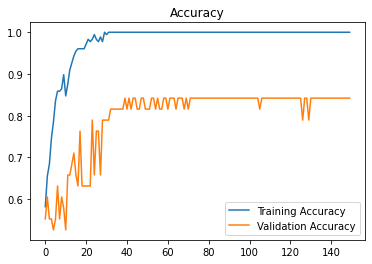

In [ ]:
# Plot Loss & Accuracy


def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)

In [ ]:
## Results
best_model = load_model(filepath='/content/drive/MyDrive/Model/cnn-parameters-improvement-08-0.85.model')

In [ ]:
best_model.metrics_names

['loss', 'accuracy']

In [ ]:
loss, accuracy = best_model.evaluate(x=x_test, y=y_test)

2/2 [==============================] - 1s 117ms/step - loss: 0.2073 - accuracy: 0.9211


In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.20729583501815796
Test Accuracy = 0.9210526347160339


In [ ]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")


# the whole data
data_percentage(y)

Number of examples: 253
Percentage of positive examples: 61.26482213438735%, number of pos examples: 155
Percentage of negative examples: 38.73517786561265%, number of neg examples: 98


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 177
Percentage of positive examples: 59.887005649717516%, number of pos examples: 106
Percentage of negative examples: 40.112994350282484%, number of neg examples: 71
Validation Data:
Number of examples: 38
Percentage of positive examples: 55.26315789473684%, number of pos examples: 21
Percentage of negative examples: 44.73684210526316%, number of neg examples: 17
Testing Data:
Number of examples: 38
Percentage of positive examples: 73.6842105263158%, number of pos examples: 28
Percentage of negative examples: 26.31578947368421%, number of neg examples: 10


In [ ]:
import json
from keras.models import model_from_json, load_model

# Save Weights + Architecture
model.save_weights('Brain Tumor.h5')
with open('Brain Tumor.json', 'w') as f:
    f.write(model.to_json())

# Load Weights + Architecture
with open('Brain Tumor.json', 'r') as f:
    new_model = model_from_json(f.read())
new_model.load_weights('Brain Tumor.h5')

In [ ]:
from tensorflow.keras.models import load_model
from keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = model_from_json(open("Brain Tumor.json", "r").read())  
model.load_weights('Brain Tumor.h5')

In [ ]:
#Loading image for predection 
def process_image(path):
  img = load_img(path, target_size = (240,240))
  img_tensor = img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis = 0)
  img_tensor/=255.0
  return img_tensor

path1 = '/content/drive/MyDrive/Brain Tumor/Dataset/yes/Y104.jpg'
img_original1 = load_img(path1)
path2 = '/content/drive/MyDrive/Brain Tumor/Dataset/yes/Y107.jpg'
img_original2 = load_img(path2)
path3 = '/content/drive/MyDrive/Brain Tumor/Dataset/no/18 no.jpg'
img_original3 = load_img(path3)

In [ ]:
pred1 = model.predict(process_image(path1))
print("Pred1 = ",pred1)

pred2 = model.predict(process_image(path2))
print("Pred2 = ",pred2)

pred3 = model.predict(process_image(path3))
print("Pred3 = ",pred3)

Pred1 =  [[0.99986076]]
Pred2 =  [[0.9434231]]
Pred3 =  [[0.10414919]]


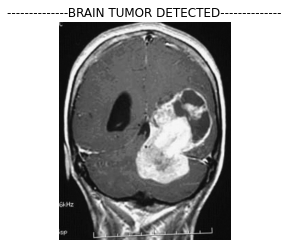

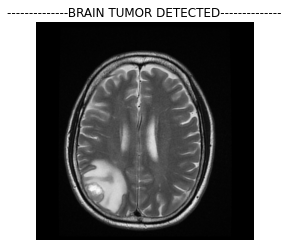

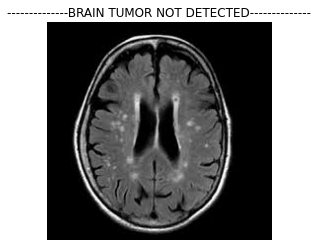

In [ ]:
def show(pred,img):

  if pred>0.5: str = '--------------BRAIN TUMOR DETECTED--------------'
  else: str = '--------------BRAIN TUMOR NOT DETECTED--------------'

  plt.imshow(img)
  plt.axis('off')
  plt.title(str)
  plt.show()

show(pred1,img_original1)
show(pred2,img_original2)
show(pred3,img_original3)